In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [26]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

def cifar_target_tranform(input):
    return torch.tensor([input]).float()

ds_train = datasets.ImageFolder("../data/cifar2/train/",
            transform = transform_train, target_transform = cifar_target_tranform)
ds_valid = datasets.ImageFolder("../data/cifar2/test/",
            transform = transform_train, target_transform = cifar_target_tranform)

print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [27]:
dl_train = DataLoader(ds_train, batch_size = 50, shuffle = True)
dl_valid = DataLoader(ds_valid, batch_size = 50, shuffle = True)

In [30]:
# Pytorch的图片默认顺序是BCWH
for step, (features, labels) in enumerate(dl_train, 1):
    print(features.shape, labels.shape)
    break

1 torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


In [60]:
torch.nn.Module?

Init signature: torch.nn.Module()
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.
:vartype training: bool
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File: 

In [57]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # (N, 3, 32, 32) -> conv2d -> (N, 32, 30, 30)
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        # (N, 32, 30, 30) -> maxpool2d -> (N, 32, 15, 15)
        self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)

        # (N, 32, 15, 15) -> conv2d -> (N, 64, 11, 11)
        self.conv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5)
        self.dropout = torch.nn.Dropout2d(p = 0.1)
        # (N, 64, 11, 11) -> conv2d -> (N, 64, 1, 1)
        self.adaptive_pool = torch.nn.AdaptiveMaxPool2d((1, 1))
        # (N, 64, 1, 1) -> flatten -> (N, 64)
        self.flatten = torch.nn.Flatten()

        # (N, 64) -> linear -> (N, 32)
        self.linear1 = torch.nn.Linear(64, 32)
        self.relu = torch.nn.ReLU()

        # (N, 32) -> linear -> (N, 1)
        self.linear2 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [32]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred, y_true: roc_auc_score(y_true.data.numpy(), y_pred.data.numpy())
model.metric_name = "auc"

In [33]:
def train_step(model, features, labels):
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(), metric.item()

def valid_step(model, features, labels):
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions, labels)
        metric = model.metric_func(predictions, labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features, labels = next(iter(dl_train))
train_step(model, features, labels)

(0.6940114498138428, 0.3974358974358974)

In [34]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch", "loss", metric_name, "val_loss", "val_" + metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("==========" * 8 + "%s" % nowtime)

    for epoch in range(1, epochs + 1):
        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):
            loss,metric = train_step(model, features, labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step % log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum / step, metric_sum / step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):
            val_loss, val_metric = valid_step(model, features, labels)
            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum / step, metric_sum / step, val_loss_sum / val_step, val_metric_sum / val_step)
        dfhistory.loc[epoch - 1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f, " + metric_name + " = %.3f, val_loss = %.3f, " + "val_" + metric_name + " = %.3f") % info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n" + "==========" * 8 + "%s" % nowtime)

    print('Finished Training...')
    
    return dfhistory

In [35]:
epochs = 20

dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq = 50)
dfhistory

Start Training...
================================================================================2020-12-03 14:45:47
[step = 50] loss: 0.693, auc: 0.551
[step = 100] loss: 0.691, auc: 0.622
[step = 150] loss: 0.690, auc: 0.661
[step = 200] loss: 0.689, auc: 0.684

EPOCH = 1, loss = 0.689, auc = 0.684, val_loss = 0.682, val_auc = 0.803

================================================================================2020-12-03 14:46:55
[step = 50] loss: 0.681, auc: 0.773
[step = 100] loss: 0.680, auc: 0.775
[step = 150] loss: 0.678, auc: 0.779
[step = 200] loss: 0.675, auc: 0.783

EPOCH = 2, loss = 0.675, auc = 0.783, val_loss = 0.660, val_auc = 0.812

================================================================================2020-12-03 14:47:20
[step = 50] loss: 0.657, auc: 0.796
[step = 100] loss: 0.654, auc: 0.784
[step = 150] loss: 0.650, auc: 0.786
[step = 200] loss: 0.645, auc: 0.789

EPOCH = 3, loss = 0.645, auc = 0.789, val_loss = 0.615, val_auc = 0.809

===================

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.688702,0.684230,0.681746,0.803470
1,2.0,0.674719,0.782804,0.660416,0.811867
2,3.0,0.644707,0.788632,0.615273,0.809103
3,4.0,0.595420,0.788649,0.555295,0.814620
4,5.0,0.557650,0.791508,0.523308,0.822030
5,6.0,0.537384,0.802379,0.508175,0.829102
6,7.0,0.528035,0.813036,0.495758,0.841791
7,8.0,0.516541,0.821542,0.489366,0.848234
8,9.0,0.507361,0.828655,0.475256,0.854429
9,10.0,0.500081,0.835320,0.466567,0.860286


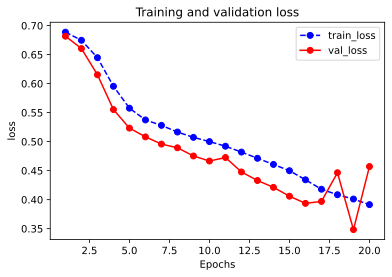

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

plot_metric(dfhistory, "loss")

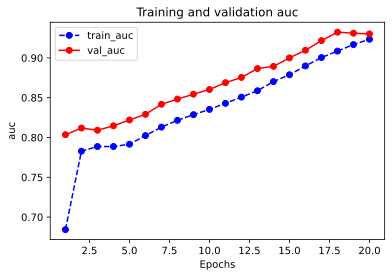

In [37]:
plot_metric(dfhistory, "auc")

In [47]:
def predict_probs(model, dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

def predict(model, dl, threshold = 0.5):
    y_pred_probs = predict_probs(model, dl)
    return torch.where(y_pred_probs > threshold, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

#预测类别
y_pred = predict(model, dl_valid)
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [41]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [48]:
# 保存模型参数
torch.save(model.state_dict(), "../data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("../data/model_parameter.pkl"))

predict(net_clone, dl_valid)

tensor([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]])